# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 

## Ideas for Lane Detection Pipeline

Steps we’ve covered so far:

    Camera calibration
    Distortion correction
    Color/gradient threshold
    Perspective transform (warp)

After doing these steps, you’ll be given two additional steps for the project:

    Detect lane lines
    Determine the lane curvature

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Camera Calibration

In [2]:
def camera_calibration(img_dir, nx=9, ny=6):
    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    img_files = glob.glob(img_dir + '/calibration*.jpg')
    for _, img_file in enumerate(img_files):
        img = cv2.imread(img_file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

In [3]:
mtx, dist = camera_calibration('./camera_cal')

## Define *correct_distortion_image* to correct distortion of an RGB image

In [4]:
# Assume img is in RGB color space
def correct_distortion_image(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

Text(0.5,1,'Undistorted Image')

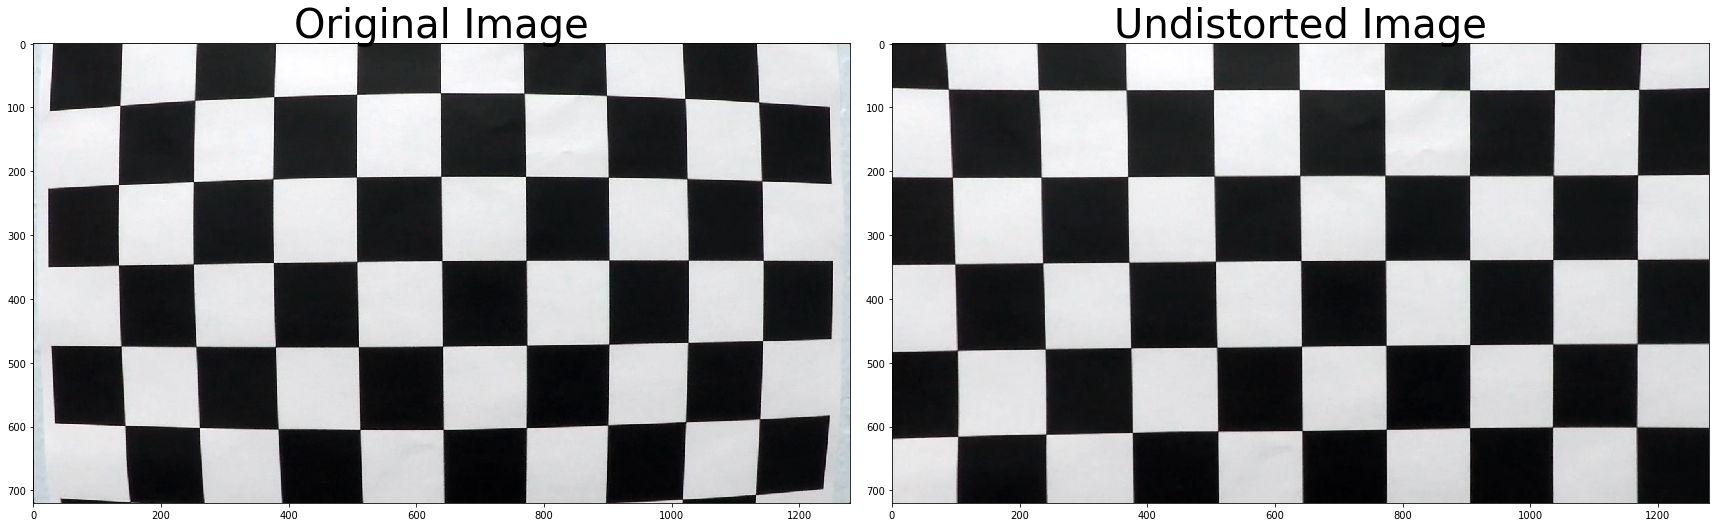

In [5]:
img = cv2.imread('./camera_cal/calibration1.jpg')
undist_img = correct_distortion_image(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=40)

## Define *Color / Gradient threshold* to apply color and gradient thresholding

In [6]:
def color_gradient_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

## Stacked thresholds and Combined S channel and Gradient threshold on a test image

Text(0.5,1,'Combined S channel and gradient thresholds')

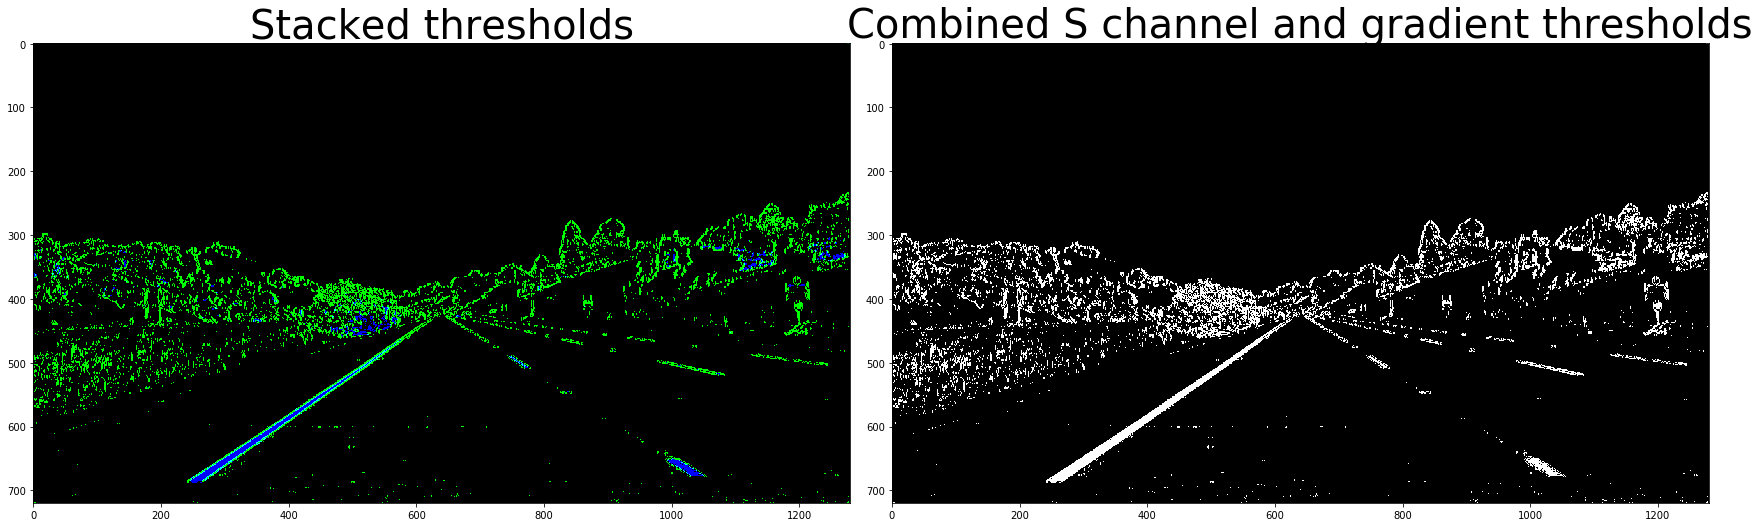

In [7]:
image = mpimg.imread('test_images/straight_lines1.jpg')

color_binary, combined_binary = color_gradient_threshold(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(color_binary)
ax1.set_title('Stacked thresholds', fontsize=40)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined S channel and gradient thresholds', fontsize=40)


In [8]:
def init_warper_parameters(img):
    global srcpts, dstpts, M, Minv
    img_size = (img.shape[1], img.shape[0])
   
    srcpts = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 20), img_size[1]],
        [(img_size[0] * 5 / 6) + 20, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dstpts = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(srcpts, dstpts)
    Minv = cv2.getPerspectiveTransform(dstpts, srcpts)
    #warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return

In [9]:
def warper(img):
    img_size = (img.shape[1], img.shape[0])
    try:
        srcpts
    except NameError:
        init_warper_parameters(img)
    init_warper_parameters(img)  
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

## Warping a test image

[[[ 585  460]]

 [[ 193  720]]

 [[1086  720]]

 [[ 695  460]]]
[[[320   0]]

 [[320 720]]

 [[960 720]]

 [[960   0]]]


Text(0.5,1,'Warped Image')

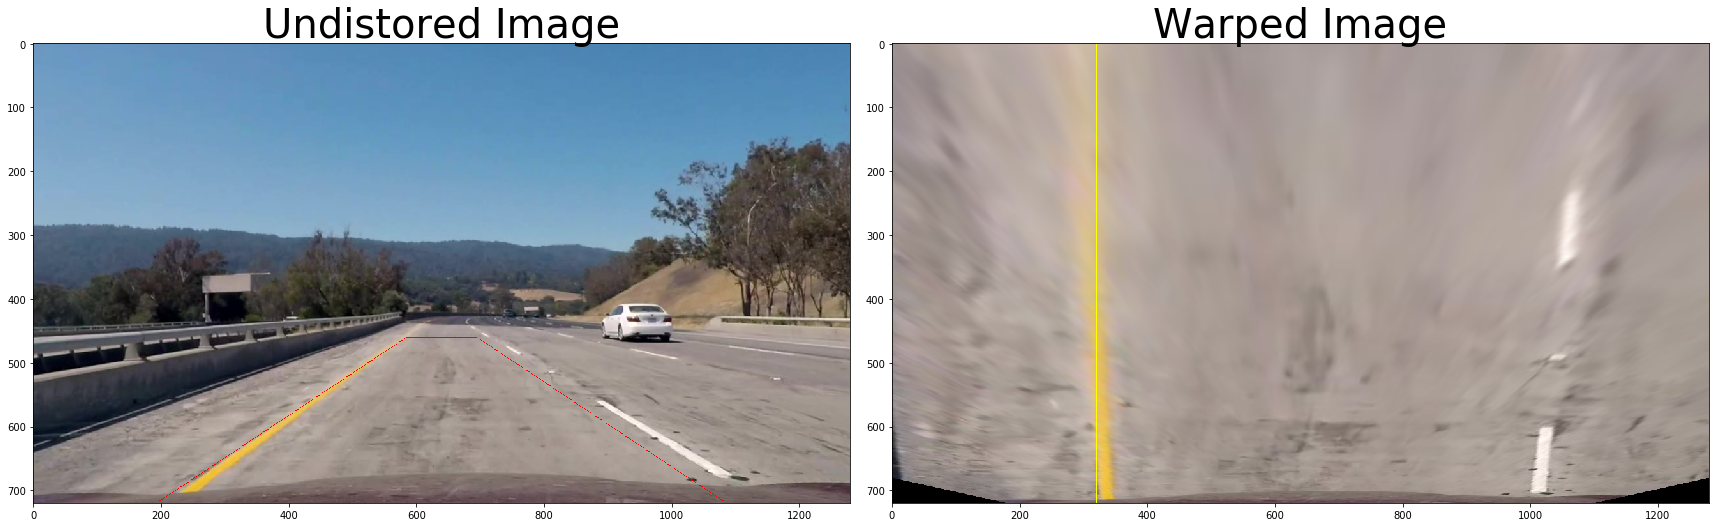

In [10]:
img = mpimg.imread('test_images/straight_lines2.jpg')
img = mpimg.imread('frames/output_025.jpg')

undist= img
dst = cv2.undistort(img, mtx, dist, None, mtx)
#warped_image,srcpts, dstpts,M,Minv = warper(dst)
warped_image = warper(dst)

srcpts = srcpts.astype(int)
srcpts = srcpts.reshape((-1,1,2))
dstpts = dstpts.astype(int)
dstpts = dstpts.reshape((-1,1,2))
print(srcpts)
print(dstpts)
cv2.polylines(dst,[srcpts],True,(255,0,0))
cv2.polylines(warped_image, [dstpts], True, (255,255,0))
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(dst)
ax1.set_title('Undistored Image', fontsize=40)

ax2.imshow(warped_image)
ax2.set_title('Warped Image', fontsize=40)

## Example: Correct Distortion -> Apply Color & Gradient threshold -> Warp

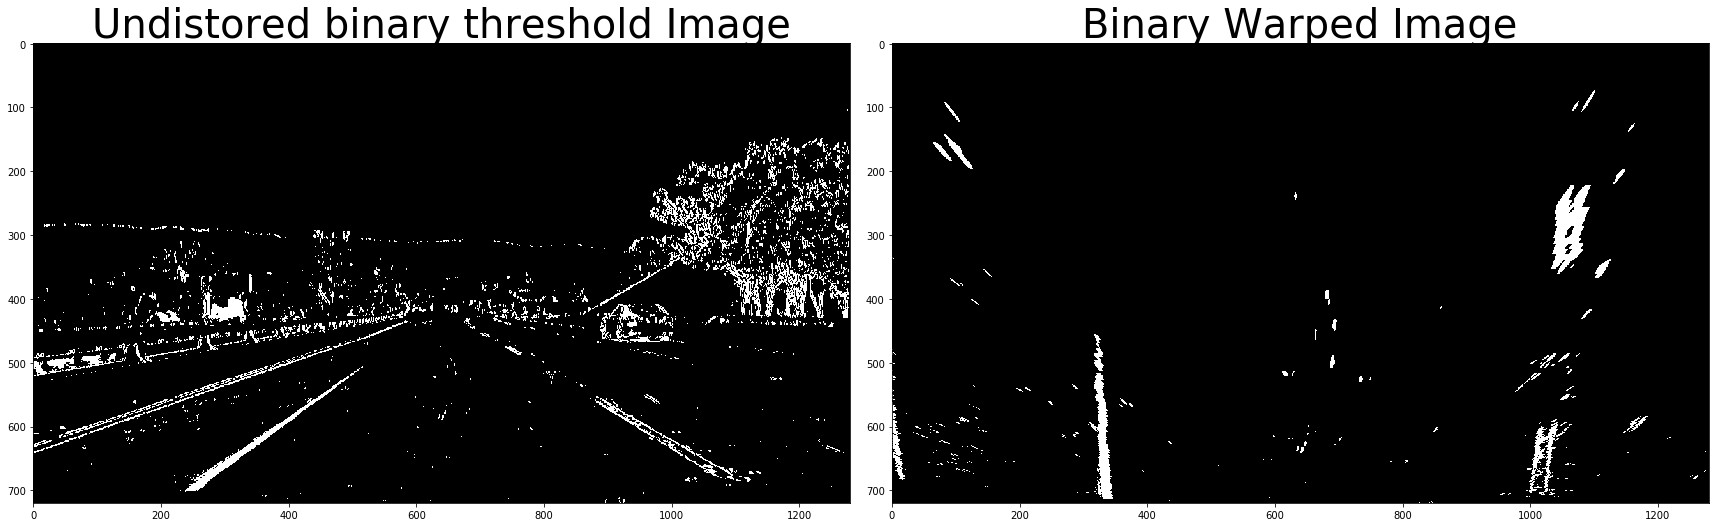

In [11]:
image = mpimg.imread('test_images/straight_lines1.jpg')
image = mpimg.imread('frames/output_025.jpg')

# Correct Distortion
dst = cv2.undistort(image, mtx, dist, None, mtx)

# Apply Color & Gradient threshold
color_binary, combined_binary = color_gradient_threshold(dst)

# Warp
binary_warped_image = warper(combined_binary)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Undistored binary threshold Image', fontsize=40)

ax2.imshow(binary_warped_image, cmap='gray')
ax2.set_title('Binary Warped Image', fontsize=40)

binary_warped = binary_warped_image

##  Line Finding Method: Peaks in a Histogram

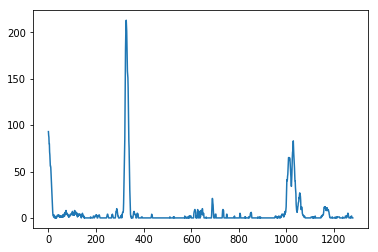

In [12]:
import numpy as np
histogram = np.sum(binary_warped[binary_warped.shape[0]//3*2:,:], axis=0)
#histogram[:250] = [0 for h in histogram[:250]]

plt.plot(histogram)

## Implement Sliding Windows and Fit a Polynomial

(720, 0)

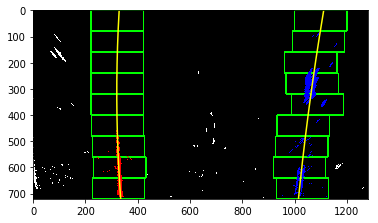

In [13]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
#histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
histogram = np.sum(binary_warped[binary_warped.shape[0]//3*2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3 ) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



In [14]:
def sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    histogram = np.sum(binary_warped[binary_warped.shape[0]//3*2:,:], axis=0)

    #histogram[:250] = [0 for h in histogram[:250]]

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3 ) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    return out_img, ploty, left_lane_inds, right_lane_inds, left_fitx, right_fitx

## Find lines using the previous line position (No sliding window needed)

In [15]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100

left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

## Fill the rectangles

(720, 0)

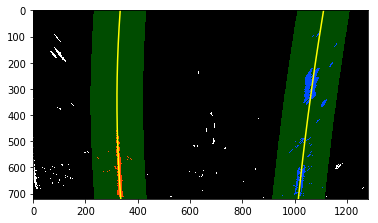

In [16]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [17]:
def fill_lane_rectangle(binary_warped, left_lane_inds, right_lane_inds):
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return result

## Measuring Curvature

In [18]:
def measure_curvature(ploty, left_fitx, right_fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad

## Final drawing

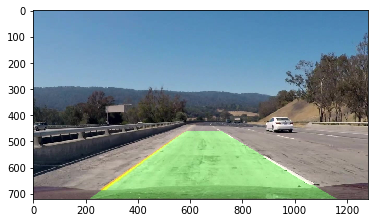

In [19]:
# Create an image to draw the lines on
warped = binary_warped
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [20]:
def fill_lane(image, warped, ploty, left_fitx, right_fitx):    # Create an image to draw the lines on
    global valid_ploty, valid_left_fitx, valid_right_fitx
    global valid_left_curverad, valid_right_curverad
    global valid_center, valid_offset
    global valid_left_bottomx, valid_right_bottomx

    try:
        valid_center
    except NameError:
        valid_center = None
        valid_left_curverad = None
        valid_right_curverad = None
        valid_left_bottomx = None
        valid_right_bottomx = None
        valid_offset = None
    
    left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)
    center = (left_fitx[719] + right_fitx[719])/2
    curr_left_curverad = left_curverad
    curr_right_curverad = right_curverad
    
    if valid_center is None:
        detected = True
    elif abs(valid_left_bottomx - left_fitx[719]) > 50:
        detected = False
    elif abs(valid_right_bottomx - right_fitx[719]) > 50:
        detected = False
    elif abs(valid_center - center) > 50:
        detected = False
    elif (valid_left_curverad > left_curverad) and (valid_left_curverad/left_curverad > 10):
        detected = False
    elif (left_curverad > valid_left_curverad) and (left_curverad/valid_left_curverad > 10):
        detected = False
    elif (valid_right_curverad > right_curverad) and (valid_right_curverad/right_curverad > 10):
        detected = False
    elif (right_curverad > valid_right_curverad) and (right_curverad/valid_right_curverad > 10):
        detected = False
    else:
        detected = True
    
    if detected == False: 
        # use the previous good ploty, left_fitx, right_fitx
        #print("Use previous !!!")
        ploty = valid_ploty
        left_fitx = valid_left_fitx
        right_fitx = valid_right_fitx
        center = valid_center
        left_curverad = valid_left_curverad
        right_curverad = valid_right_curverad
    else:
        valid_ploty = ploty
        valid_left_fitx = left_fitx
        valid_right_fitx = right_fitx
        valid_center = center
        valid_left_curverad = left_curverad
        valid_right_curverad = right_curverad
        valid_left_bottomx = left_fitx[719]
        valid_right_bottomx = right_fitx[719]
        valid_offset = center - image.shape[1]/2
        
    #warped = binary_warped
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, '[Curvature] Left : ' + str(int(left_curverad)) + ' m / Right : ' + str(int(right_curverad)) + ' m', (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2,cv2.LINE_AA) 
    #cv2.putText(result, '[Curr Curvature] Left : ' + str(curr_left_curverad) + ' / Right : ' + str(curr_right_curverad), (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2,cv2.LINE_AA) 
    cv2.putText(result, '[Center] ' + str(center), (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2,cv2.LINE_AA) 
    cv2.putText(result, '[Offset] ' + str(valid_offset), (100,250), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2,cv2.LINE_AA) 
    cv2.putText(result, 'Udacity Self Driving Car Nanodegree | muhyun.kim@gmail.com', (700,700), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255),2,cv2.LINE_AA) 
    #plt.imshow(result)
    return result

In [21]:
# Test pipe on an image

#image = mpimg.imread('test_images/straight_lines1.jpg')

def process_image(image):
    undist_image = correct_distortion_image(image)
    color_binary, combined_binary = color_gradient_threshold(undist_image)
    binary_warped = warper(combined_binary)
    lanes_image, ploty, left_lanes_inds, right_lane_inds, left_fitx, right_fitx = sliding_window(binary_warped)
    #processed_image = fill_lane_rectangle(binary_warped, left_lane_inds, right_lane_inds)
    processed_image = fill_lane(undist_image, binary_warped, ploty, left_fitx, right_fitx)
    return processed_image

#processed = process_image(image)
#plt.imshow(processed)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [23]:
valid_center = None

white_output = 'project_video_result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(35,36)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [02:40<00:00,  8.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 2min 50s, sys: 32.6 s, total: 3min 23s
Wall time: 2min 41s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))